# Predicting Mortality Challenge 
The Vertex team provided the following question for Patrick Cronin to answer and present results.  

The PhysioNet Challenge 2012 dataset (Silva et al., 2012) is a collection of multivariate clinical time-series data from 4000 intensive care patient records, publicly available at https://physionet.org/challenge/2012/. Each record is a time series of roughly 48 hours and contains 37 variables such as pH, heart rate, and glucose level. Set A and the associated outcomes are attached to this email. Only using the provided dataset, predict whether a patient will die in the hospital.

Based on the above challenge and a further reading of the PsioNet challenge, please note the following assumptions:

* All data is collected during the first 48 hours of admission
* All patients survivied the first 48 hours of admission and those who died did so during thier hospital stay 
* The only variable from the outcome-related descriptors that will be used is `in-hosptial death`.  All other variables cannot be use for prediction
* There is no indication that there are any variables in the file `seta_data.csv` that would not be available when the model would need to be run, and there is no risk of [target leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning))

Please note the following:

* After cloning the repository unzip the file `DSS_data.zip`.  It will create the subfolder `\DSS_data` and the notebook should be able to run as is.
* Logistic regression was used to create the prediction model.

## Setup
Below are the packages that need to be imported for this challenge

In [1]:
# pandas & numpy
import pandas as pd
import numpy as np

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.calibration import CalibrationDisplay
from sklearn import metrics

# Visualization packages 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Set Jupyer notebook to display multiple outputs from a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Turn off warnings to clean up output
import warnings
warnings.filterwarnings('ignore')

# Import Data
This section imports all of the necessary data for this project


## tgt_df
Import the file `Outcomes-a.txt`, and rename it `tgt_df` (target), and clean up the variables to make them easier for downstream usage.  After review please note the following:

* There are 4000 patients and no duplicate ids.  It's safe to make the id the index
* 13.9% of the population died during their hospital stay.
* Given that there are ~554 patients who perished and logistic regression will be used to develop a model with a 20% holdout, it's safe to say that approximately 40 features could be created without too much of a risk for overfitting.
  * After the group is split features will be created for both populations; however, when exploring the data only the training group will be used to look at summary statistic.  This is to ensure that the 20% testing set is a true holdout.
  
Observations were assigned to training and testing in this step so that when exploratory metrics were calculated the testing set was not used.

In [2]:
# Import file and clean up columns to only include outcome of interest
tgt_df = pd.read_csv("DSS_data/Outcomes-a.txt")
tgt_df.columns = tgt_df.columns.str.lower()
tgt_df = tgt_df[['recordid','in-hospital_death']]
tgt_df.columns = ['id','death']

# Review summary statistics
len(tgt_df)
tgt_df.index.nunique()
tgt_df.dtypes
tgt_df.death.sum()

# Set index for easier joins
tgt_df.set_index('id', inplace=True)

4000

4000

id       int64
death    int64
dtype: object

554

The data will be split 80:20 into training an testing.  A random state will be initaited so that the randomization is the same everytime the file is run.  The data is being split so early so that when summary statistics are being reviewed they can easily only be reviewed on the training set.

In [3]:
# Split into training and testing and confirm that the counts look correct
train, test = train_test_split(tgt_df, test_size=0.2, random_state=5)
train['group'] = 'train'
test['group'] = 'test'
tgt_df = pd.concat([train,test])
del train, test

# Review data summary stats
len(tgt_df)
tgt_df.index.nunique()
tgt_df.groupby('group').agg('count')

4000

4000

,death
group,
test,800
train,3200


## seta_df
Import the time series measurements and clean the following:

* Create the hour of the observation instead of the time stamp
* Clean up column names
* Make all `param` values lowercase to reduce coding mistakes later.
* Ensure there are no null Values
* Set `id` to index to make future joins faster and require less code.

In [4]:
# Import data and clean columns
seta_df = pd.read_csv("DSS_data/seta_data.csv",
                      dtype={'PATIENT_ID':int,
                             'Parameter':object,
                             'Time':object,
                             'Value':'float64'})
seta_df.columns = ['id','param','time', 'value']
seta_df['hour'] = seta_df['time'].str.slice(0,2).astype(int)
seta_df['param'] = seta_df['param'].str.lower()

# Review summary stats of the data
seta_df.head(3)
seta_df.dtypes
len(seta_df)
seta_df.nunique()

# Set id to index
seta_df.set_index('id', inplace=True)

,id,param,time,value,hour
0,132539,recordid,00:00,132539.0,0
1,132539,age,00:00,54.0,0
2,132539,gender,00:00,0.0,0


id         int64
param     object
time      object
value    float64
hour       int64
dtype: object

1757980

id       4000
param      42
time     2881
value    7579
hour       49
dtype: int64

In [5]:
# Confirm there are no null values
seta_df['param'].isnull().sum()
seta_df['time'].isnull().sum()
seta_df['value'].isnull().sum()

0

0

0

In [6]:
# Review basic stats of the param values
(seta_df[['param','value']]
 .groupby('param')
 .agg(['mean','median','min','max']))

value                                 
                      mean     median        min        max
param                                                      
age              64.247500      67.00      15.00      90.00
albumin           2.922326       2.90       1.00       5.30
alp             116.773286      82.00      12.00    2205.00
alt             394.474976      43.00       1.00   11470.00
ast             506.284098      64.00       4.00   18430.00
bilirubin         2.908555       0.90       0.10      47.70
bun              27.416528      20.00       0.00     197.00
cholesterol     156.517460     152.00      28.00     330.00
creatinine        1.504977       1.00       0.10      22.10
diasabp          59.290512      58.00       0.00     268.00
fio2              0.545201       0.50       0.21       1.00
gcs              11.398714      13.00       3.00      15.00
gender            0.560750       1.00      -1.00       1.00
glucose         141.509561     127.00      10.00    1143.00
hco3             23.115742      23.00       5.00      50.00
hct              30.679043      30.30       9.00      61.80
height           88.919475     152.40      -1.00     431.80
hr               87.517442      86.00       0.00     300.00
icutype           2.760000       3.00       1.00       4.00
k                 4.136219       4.10       1.80      22.90
lactate           2.924779       2.10       0.30      29.30
map              79.742927      77.00       0.00     300.00
mechvent          1.000000       1.00       1.00       1.00
mg                2.027910       2.00       0.60       9.90
na              139.075829     139.00      98.00     177.00
nidiasabp        57.953864      56.00       0.00     201.00
nimap            76.780450      75.00       0.00     209.00
nisysabp        118.594024     116.00       0.00     296.00
paco2            40.474748      39.00       0.30     100.00
pao2            150.415269     121.00       0.00     500.00
ph                7.489200       7.38       1.00     735.00
platelets       190.815719     172.00       6.00    1047.00
recordid     137605.122000  137592.50  132539.00  142673.00
resprate         19.723729      19.00       0.00      98.00
sao2             96.637068      97.00      26.00     100.00
sysabp          118.697899     116.00       0.00     295.00
temp             37.007651      37.10     -17.80      42.10
troponini         7.151264       2.60       0.30      49.20
troponint         1.198451       0.20       0.01      24.91
urine           120.798728      70.00       0.00   11000.00
wbc              12.670084      11.40       0.10     187.50
weight           83.386615      80.60      -1.00     300.00

## labs_df
The 37 time series measures are split out into a separate dataframe because the logic needed to treat them is different from the measure that are no time series.  This will make downstream programming easier without worrying about ignoring static values.

* The column `day` will added to make it easy to create features aggregated from the first or second day of the hospital admission.

In [7]:
# Confirm the 37 measures are identified and data looks right
admit_measures = ['age','icutype','height','gender','recordid']
labs_df = seta_df.loc[~seta_df['param'].isin(admit_measures)]
labs_df['day'] = np.where(labs_df.hour < 24,1,2)
labs_df = labs_df.join(tgt_df)

# Review table stats
labs_df.param.nunique()
labs_df[['day','param']].groupby('day').agg('count')
labs_df.head(3)

37

,param
day,
1,956681
2,781299


,param,time,value,hour,day,death,group
id,,,,,,,
132539,weight,00:00,-1.0,0,1,0,test
132539,gcs,00:07,15.0,0,1,0,test
132539,hr,00:07,73.0,0,1,0,test


In [8]:
# Review remaining measurements for clues
(labs_df.reset_index()[['param','value','id','hour']]
 .groupby('param')
 .agg(['count','nunique','min','median','max'])
 .sort_values(by = [('id','count')], ascending=False))

value                                       id                  \
              count nunique    min  median       max   count nunique     min   
param                                                                          
hr           228538     193   0.00   86.00    300.00  228538    3937  132539   
map          145760     288   0.00   77.00    300.00  145760    2792  132540   
sysabp       145650     238   0.00  116.00    295.00  145650    2799  132540   
diasabp      145567     169   0.00   58.00    268.00  145567    2799  132540   
urine        136918     553   0.00   70.00  11000.00  136918    3883  132539   
weight       129165     996  -1.00   80.60    300.00  129165    4000  132539   
nisysabp      98331     212   0.00  116.00    296.00   98331    3493  132539   
nidiasabp     98210     154   0.00   56.00    201.00   98210    3483  132539   
nimap         96871     409   0.00   75.00    209.00   96871    3481  132539   
temp          86405     137 -17.80   37.10     42.10   86405    3936  132539   
gcs           61563      13   3.00   13.00     15.00   61563    3936  132539   
resprate      55051      64   0.00   19.00     98.00   55051    1101  132539   
fio2          32390      37   0.21    0.50      1.00   32390    2717  132540   
mechvent      31144       1   1.00    1.00      1.00   31144    2529  132540   
ph            24355      91   1.00    7.38    735.00   24355    3040  132540   
paco2         23293      90   0.30   39.00    100.00   23293    3023  132540   
pao2          23268     480   0.00  121.00    500.00   23268    3023  132540   
hct           18271     368   9.00   30.30     61.80   18271    3936  132539   
k             14440      80   1.80    4.10     22.90   14440    3904  132539   
platelets     14104     640   6.00  172.00   1047.00   14104    3932  132539   
creatinine    13983     145   0.10    1.00     22.10   13983    3936  132539   
bun           13916     173   0.00   20.00    197.00   13916    3936  132539   
hco3          13613      44   5.00   23.00     50.00   13613    3924  132539   
mg            13590      51   0.60    2.00      9.90   13590    3897  132539   
na            13570      73  98.00  139.00    177.00   13570    3925  132539   
glucose       13021     471  10.00  127.00   1143.00   13021    3887  132539   
wbc           12910     455   0.10   11.40    187.50   12910    3927  132539   
sao2           8185      47  26.00   97.00    100.00    8185    1792  132540   
lactate        8024     201   0.30    2.10     29.30    8024    2183  132541   
bilirubin      3191     243   0.10    0.90     47.70    3191    1718  132541   
ast            3182     812   4.00   64.00  18430.00    3182    1725  132541   
alt            3177     753   1.00   43.00  11470.00    3177    1721  132541   
alp            3092     387  12.00   82.00   2205.00    3092    1690  132541   
albumin        2356      41   1.00    2.90      5.30    2356    1615  132541   
troponint      2126     451   0.01    0.20     24.91    2126     863  132584   
troponini       435     163   0.30    2.60     49.20     435     205  132547   
cholesterol     315     140  28.00  152.00    330.00     315     305  132547   

                                 hour                         
               median     max   count nunique min median max  
param                                                         
hr           137600.0  142673  228538      49   0   21.0  48  
map          137679.0  142673  145760      49   0   21.0  48  
sysabp       137678.0  142673  145650      49   0   21.0  48  
diasabp      137678.0  142673  145567      49   0   21.0  48  
urine        137600.0  142673  136918      49   0   23.0  48  
weight       137487.0  142673  129165      49   0   24.0  48  
nisysabp     137556.0  142673   98331      49   0   21.0  48  
nidiasabp    137556.0  142673   98210      49   0   21.0  48  
nimap        137556.0  142673   96871      49   0   21.0  48  
temp         137699.0  142673   86405      49   0   20.0 

# Explore
The values of the 37 measurements will be explored in this section. This will provide clues to create in future steps.

## Var, Time, Death
Create Visualizations to understand the relationship between teh variable time and death.

In [9]:
# Create simple visualization var, time, and death
def var_time_death(df, var):
    agg_df = (df.loc[(labs_df['param'] == var),
                     ['hour','value','group','death']]
              .groupby(['group','hour','id'])
              .agg('mean')
              .reset_index())
    agg_df['color'] = np.where(agg_df.death == 1,'r','b')
    return sns.lineplot(data=agg_df, x="hour", y="value", hue="death").set(title=var)

In [10]:
# Identify all unique tests to copy into the graphs
np.sort(labs_df.param.unique())

array(['albumin', 'alp', 'alt', 'ast', 'bilirubin', 'bun', 'cholesterol',
       'creatinine', 'diasabp', 'fio2', 'gcs', 'glucose', 'hco3', 'hct',
       'hr', 'k', 'lactate', 'map', 'mechvent', 'mg', 'na', 'nidiasabp',
       'nimap', 'nisysabp', 'paco2', 'pao2', 'ph', 'platelets',
       'resprate', 'sao2', 'sysabp', 'temp', 'troponini', 'troponint',
       'urine', 'wbc', 'weight'], dtype=object)

### albumin

[Text(0.5, 1.0, 'albumin')]

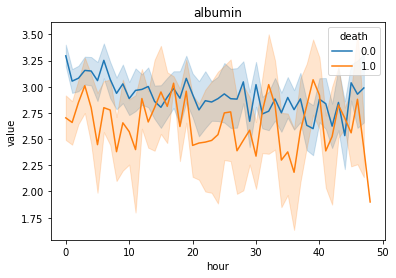

In [11]:
var_time_death(labs_df,'albumin')

### alp

[Text(0.5, 1.0, 'alp')]

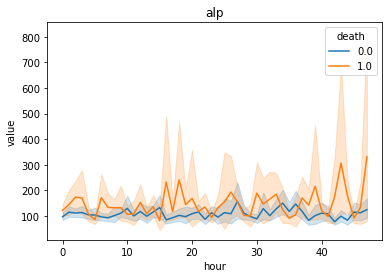

In [12]:
var_time_death(labs_df,'alp')

### alt

[Text(0.5, 1.0, 'alt')]

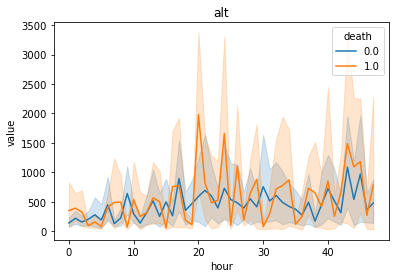

In [13]:
var_time_death(labs_df,'alt')

### ast

[Text(0.5, 1.0, 'ast')]

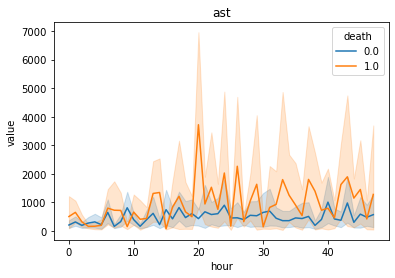

In [14]:
var_time_death(labs_df,'ast')

### bilirubin

[Text(0.5, 1.0, 'bilirubin')]

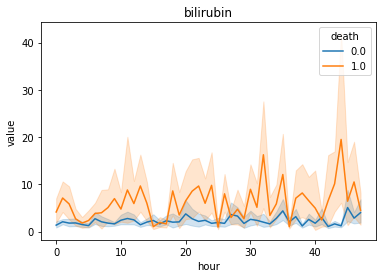

In [15]:
var_time_death(labs_df,'bilirubin')

### bun *
Those that died tended to have higher [Blood urea nitrogen](https://en.wikipedia.org/wiki/Blood_urea_nitrogen) levels.  The delta between the patients median value and the overall BUN median value will be calcualted.  Patients with a higher value were more likey to die.

[Text(0.5, 1.0, 'bun')]

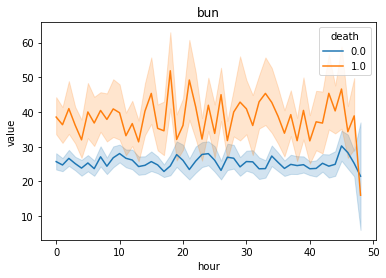

In [16]:
var_time_death(labs_df,'bun')

### cholesterol

[Text(0.5, 1.0, 'cholesterol')]

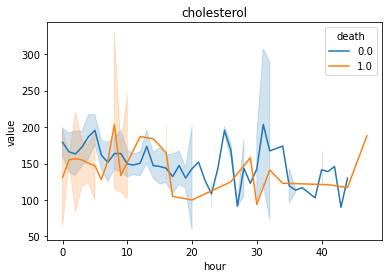

In [17]:
var_time_death(labs_df,'cholesterol')

### creatinine

[Text(0.5, 1.0, 'creatinine')]

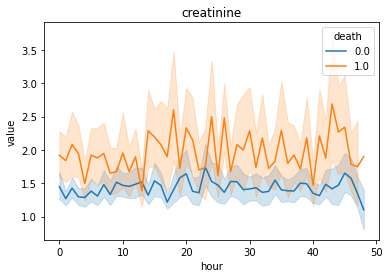

In [18]:
var_time_death(labs_df,'creatinine')

### diasabp

[Text(0.5, 1.0, 'diasabp')]

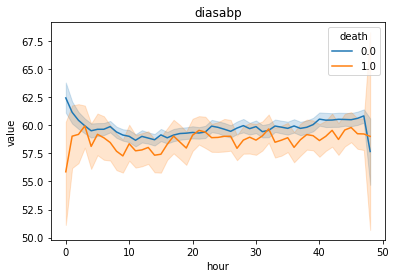

In [19]:
var_time_death(labs_df,'diasabp')

### fio2

[Text(0.5, 1.0, 'fio2')]

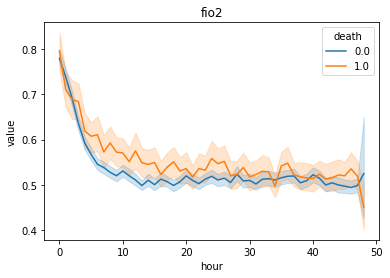

In [20]:
var_time_death(labs_df,'fio2')

### gcs*
The [Glascow Comma Scale](https://en.wikipedia.org/wiki/Glasgow_Coma_Scale) (GCS) is a measure of a patients coma status.  It's clear that if the coma status is improving the patient is much less likely to die.  A feature will be created that compares the minimum value on day 1 vs the maximm value on day 2 will be created to see if the patient is improving.

[Text(0.5, 1.0, 'gcs')]

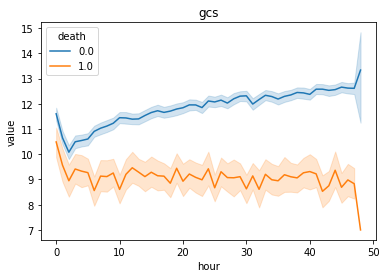

In [21]:
var_time_death(labs_df,'gcs')

### glucose

[Text(0.5, 1.0, 'glucose')]

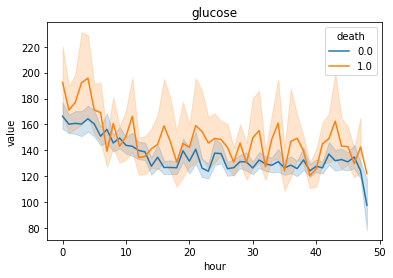

In [22]:
var_time_death(labs_df,'glucose')

### hco3

[Text(0.5, 1.0, 'hco3')]

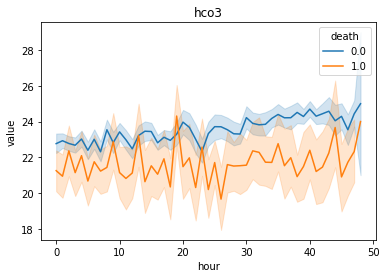

In [23]:
var_time_death(labs_df,'hco3')

### hct

[Text(0.5, 1.0, 'hct')]

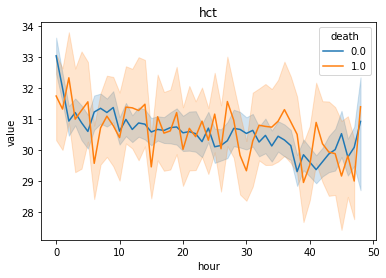

In [24]:
var_time_death(labs_df,'hct')

### hr

[Text(0.5, 1.0, 'hr')]

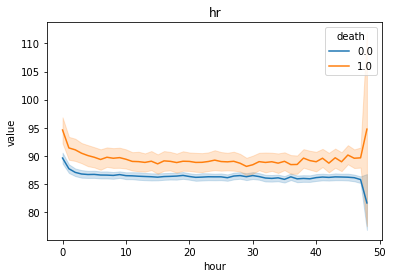

In [25]:
var_time_death(labs_df,'hr')

### k

[Text(0.5, 1.0, 'k')]

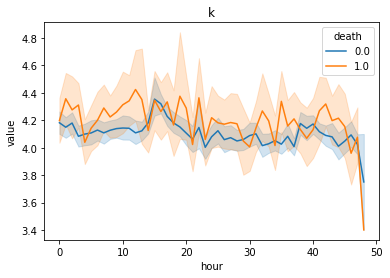

In [26]:
var_time_death(labs_df,'k')

### lactate*
The [Lactic acid](https://en.wikipedia.org/wiki/Lactic_acid) value on the second day of admission appears to be a good feature to predict death.  The delta between the the patients median on day 2 and the overall population will be calcualted for each patient.

[Text(0.5, 1.0, 'lactate')]

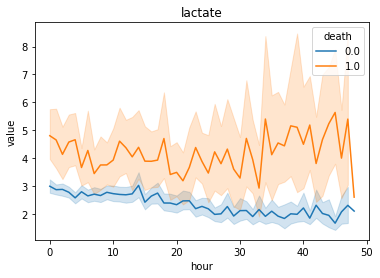

In [27]:
var_time_death(labs_df,'lactate')

### map

[Text(0.5, 1.0, 'map')]

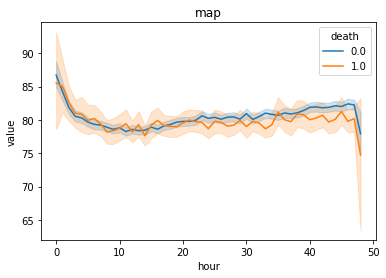

In [28]:
var_time_death(labs_df,'map')

### mechvent

[Text(0.5, 1.0, 'mechvent')]

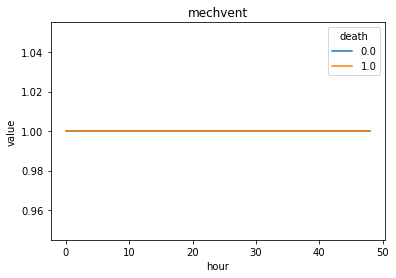

In [29]:
var_time_death(labs_df,'mechvent')

### mg

[Text(0.5, 1.0, 'mg')]

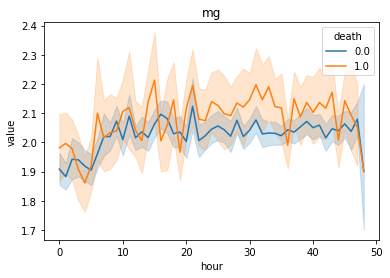

In [30]:
var_time_death(labs_df,'mg')

### na

[Text(0.5, 1.0, 'na')]

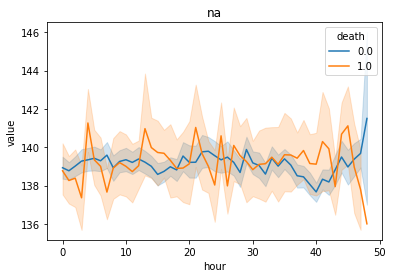

In [31]:
var_time_death(labs_df,'na')

### nidiasabp*
Patiens with a lower [Non-invasive systolic arterial blood pressure](https://en.wikipedia.org/wiki/Blood_pressure) have a greater likelihood of death.  The delta of the patients median value and the overall population median value will be calculated. 

[Text(0.5, 1.0, 'nidiasabp')]

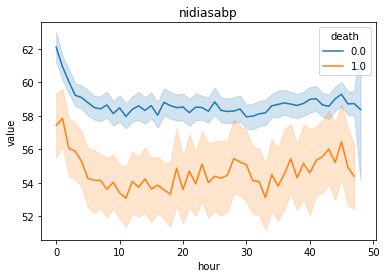

In [32]:
var_time_death(labs_df,'nidiasabp')

### nimap

[Text(0.5, 1.0, 'nimap')]

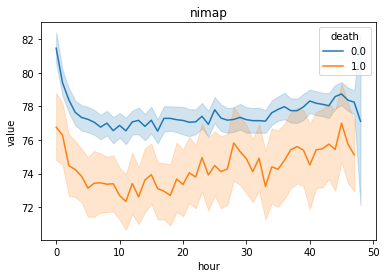

In [33]:
var_time_death(labs_df,'nimap')

### nisysabp

[Text(0.5, 1.0, 'nisysabp')]

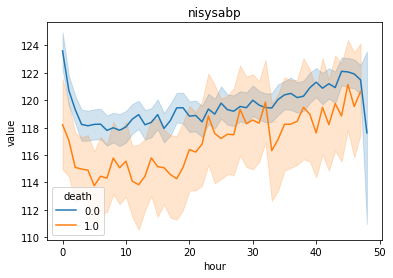

In [34]:
var_time_death(labs_df,'nisysabp')

### paco2

[Text(0.5, 1.0, 'paco2')]

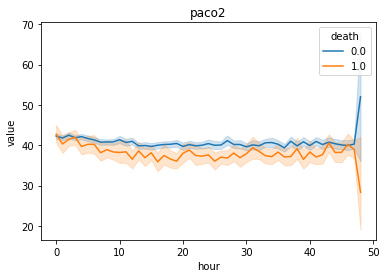

In [35]:
var_time_death(labs_df,'paco2')

### pao2

[Text(0.5, 1.0, 'pao2')]

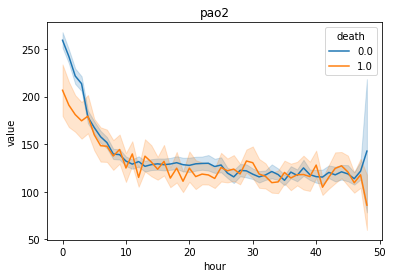

In [36]:
var_time_death(labs_df,'pao2')

### ph

[Text(0.5, 1.0, 'ph')]

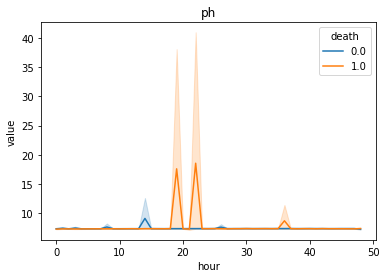

In [37]:
var_time_death(labs_df,'ph')

### platelets

[Text(0.5, 1.0, 'platelets')]

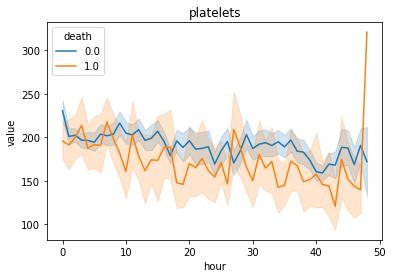

In [38]:
var_time_death(labs_df,'platelets')

### resprate

[Text(0.5, 1.0, 'resprate')]

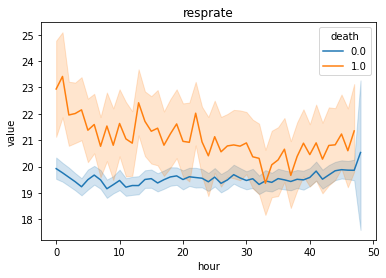

In [39]:
var_time_death(labs_df,'resprate')

### sao2

[Text(0.5, 1.0, 'sao2')]

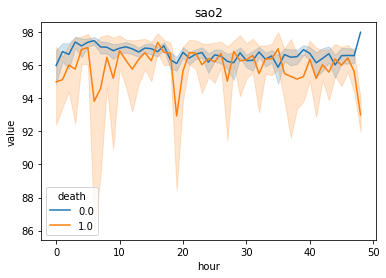

In [40]:
var_time_death(labs_df,'sao2')

### sysabp

[Text(0.5, 1.0, 'sysabp')]

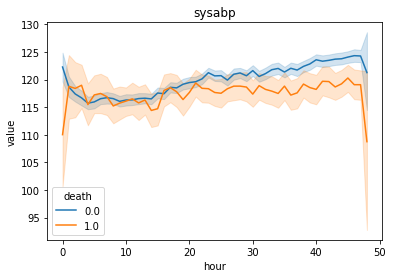

In [41]:
var_time_death(labs_df,'sysabp')

### temp*
Patients with colder temperatures had a greater risk of death and this relationship appears strongest on the second day. On day 1 there value doesn't appear very stable so the delta between the patients median value and the overall population value will be calculated for day 2.

[Text(0.5, 1.0, 'temp')]

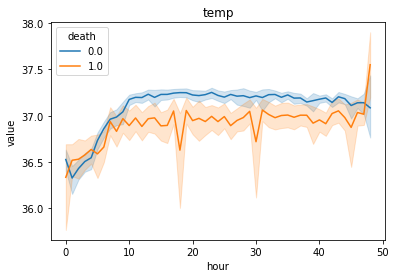

In [42]:
var_time_death(labs_df,'temp')

### troponini

[Text(0.5, 1.0, 'troponini')]

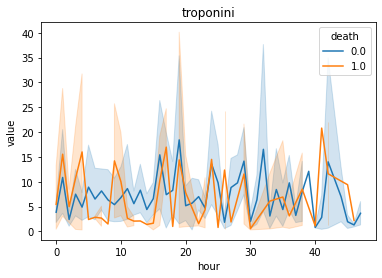

In [43]:
var_time_death(labs_df,'troponini')

### troponint

[Text(0.5, 1.0, 'troponint')]

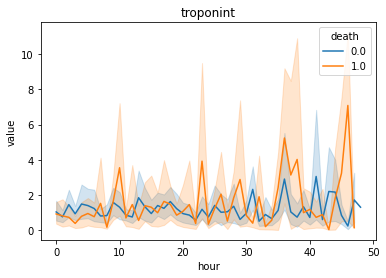

In [44]:
var_time_death(labs_df,'troponint')

### urine

[Text(0.5, 1.0, 'urine')]

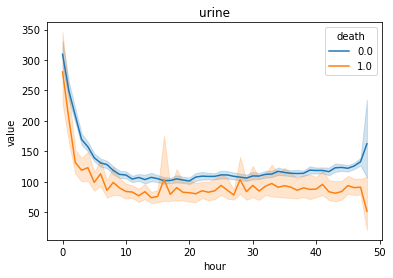

In [45]:
var_time_death(labs_df,'urine')

### wbc

[Text(0.5, 1.0, 'wbc')]

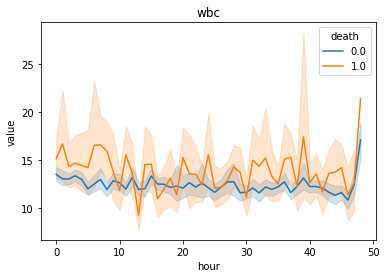

In [46]:
var_time_death(labs_df,'wbc')

### weight

[Text(0.5, 1.0, 'weight')]

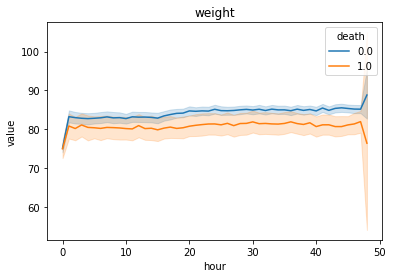

In [47]:
var_time_death(labs_df,'weight')

## labs_death_df
It's very possible that just the existance of certain labs may be a predictor for survival.  In this section work will be performed to identify if the presence of a lab test was associted with life or death.

In [48]:
# This table identfies if the patient had a lab test performed.
labs_pre_pivot = labs_df[['param']].reset_index().drop_duplicates()
labs_pre_pivot['exists'] = 1
labs_pivot = labs_pre_pivot.pivot(index='id',columns='param', values = 'exists')
labs_death_df = tgt_df.loc[tgt_df.group == 'train',['death']].join(labs_pivot).fillna(0)
labs_death_df.head()

,death,albumin,alp,alt,ast,bilirubin,bun,cholesterol,creatinine,diasabp,...,platelets,resprate,sao2,sysabp,temp,troponini,troponint,urine,wbc,weight
id,,,,,,,,,,,,,,,,,,,,,
140292,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
136392,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
139169,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
139665,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
136178,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [49]:
# This table reviews the relationship between the patient having the test and death
lab_delta_df = pd.DataFrame(columns=['lab', 'has_lab_mean', 'has_lab_count', 'no_lab_mean', 'no_lab_count',
       'lab_mean_delta'])

for param in labs_pre_pivot.param.unique():
    df = labs_death_df[['death',param]].reset_index().groupby(param).agg({'death':['mean','count']})
    df['lab'] = df.index.name
    df.reset_index(inplace=True)
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.columns =['has_lab','mean','count','lab']
    df = df[['lab','has_lab','mean', 'count']]

    df_has_lab = df[df.has_lab == 1]
    df_has_lab.columns = ['lab','has_lab','has_lab_mean','has_lab_count']
    df_no_lab  = df[df.has_lab == 0]
    df_no_lab.columns = ['lab','no_lab','no_lab_mean','no_lab_count']
    df_has_lab.reset_index(inplace=True)
    df_no_lab.reset_index(inplace=True)

    lab_comp_df = df_has_lab.join(df_no_lab[['no_lab_mean','no_lab_count']])
    lab_comp_df = lab_comp_df[['lab', 'has_lab_mean', 'has_lab_count','no_lab_mean', 'no_lab_count']]
    lab_comp_df['lab_mean_delta'] = lab_comp_df['has_lab_mean'] - lab_comp_df['no_lab_mean']
    lab_delta_df = pd.concat([lab_delta_df, lab_comp_df])

### Lab Table
This table exists to examine the relationshp between the delta between the death rate between patients who had verse didn't have a test. Please note the following


* The value `lab_mean_delta` is the difference in the mortality rate between those that recieved the lab and those that did not.
* There are a number of tests where the presense of the test has an association with death such as [Troponin](https://en.wikipedia.org/wiki/Troponin) `troponini`.
* There test for [Respiration Rate](https://en.wikipedia.org/wiki/Respiration_(physiology)) `resprate` is negatively associated with death.
* There is clear evidence that several tests appear to have been run as panels as there are groups of tests with nearly identical counts and summary statistics.  For the model only 1 feature will be created from a panel even if the rest of the featres on the panel appear to be ideal to include 

In [50]:
lab_delta_df.sort_values('lab_mean_delta', ascending=False)

,lab,has_lab_mean,has_lab_count,no_lab_mean,no_lab_count,lab_mean_delta
0,troponini,0.277108,166,0.127554,3034,0.149554
0,troponint,0.215007,693,0.113283,2507,0.101724
0,wbc,0.137087,3144,0.035714,56,0.101372
0,platelets,0.136999,3146,0.037037,54,0.099962
0,hct,0.136869,3149,0.039216,51,0.097653
0,bun,0.136782,3151,0.040816,49,0.095966
0,creatinine,0.136782,3151,0.040816,49,0.095966
0,glucose,0.137765,3114,0.046512,86,0.091253
0,alt,0.183792,1382,0.09846,1818,0.085332
0,ast,0.183394,1385,0.098623,1815,0.084771


# Raw Features
Create raw features that will be later treated for modeling

## admit_df
Identify the key values upon admission that are not part of the time series, and only exist once per admission.  The data is pivoted to created `admit_df`, and confirmed that exactly 4,000 rows of unique measures remain.

In [51]:
# Pivot Measures
admit_measures = ['age','icutype','height','gender']
admit_df = (seta_df.loc[(seta_df['time'] == '00:00') &
                        (seta_df['param'].isin(admit_measures))]
            .reset_index()
            .pivot('id','param','value'))

# Review stats
len(admit_df)
admit_df.index.nunique()
admit_df.head(3)

4000

4000

param,age,gender,height,icutype
id,,,,
132539,54.0,0.0,-1.0,4.0
132540,76.0,1.0,175.3,2.0
132541,44.0,0.0,-1.0,3.0


## has_lab_df
Identification of labs that the patient received in the ICU that appear to be of interest.  The labs that was included is in the first line.

In [52]:
lab_list = ['troponini','troponint','alt','albumin','paco2','resprate','gcs']
has_lab_df = labs_df.loc[labs_df['param'].isin(lab_list),['param']].reset_index().drop_duplicates()
has_lab_df['exists'] = 1
has_lab_df = has_lab_df.pivot(index='id',columns='param', values = 'exists').fillna(0)
len(has_lab_df)
has_lab_df.index.nunique()
has_lab_df.columns = ["has_" + x for x in has_lab_df.columns]
has_lab_df.head()

3983

3983

,has_albumin,has_alt,has_gcs,has_paco2,has_resprate,has_troponini,has_troponint
id,,,,,,,
132539,0.0,0.0,1.0,0.0,1.0,0.0,0.0
132540,0.0,0.0,1.0,1.0,0.0,0.0,0.0
132541,1.0,1.0,1.0,1.0,0.0,0.0,0.0
132543,1.0,1.0,1.0,0.0,1.0,0.0,0.0
132545,1.0,0.0,1.0,0.0,1.0,0.0,0.0


## median_delta_df
Identify distance from the median value of a lab for each patient to the overall median lab value

* bun
* nidiasabp
* lactate: Day 2 median
* temp: Day 2 median

In [53]:
# Overall median values
labs_median_df = (labs_df
                  .loc[(labs_df.param.isin(['bun','nidiasabp'])) |
                       (labs_df.param.isin(['lactate','temp'])) & (labs_df.day == 2),
                       ['param','value']]
                  .groupby('param')
                  .agg('median')
                  .reset_index())
labs_median_df.columns = ['param','lab_median']
labs_median_df.head()
labs_median_df.dtypes

,param,lab_median
0,bun,20.0
1,lactate,1.7
2,nidiasabp,56.0
3,temp,37.2


param          object
lab_median    float64
dtype: object

In [54]:
labs_to_include = ['bun','nidiasabp','temp','lactate']

# Calculate delta values between the patients median and the overall meidan
labs_no_index_df = labs_df.reset_index()
labs_median_delta_df = (labs_no_index_df
                      .loc[labs_no_index_df.param.isin(labs_to_include),
                           ['id','param','value']]
                      .groupby(['id','param'])
                      .agg('median')
                      .reset_index())

labs_median_delta_df.columns = ['id','param','pat_median']
labs_median_delta_df = labs_median_delta_df.merge(labs_median_df, on=['param'])
labs_median_delta_df['median_delta'] = labs_median_delta_df['pat_median'] - labs_median_delta_df['lab_median']

median_delta_df = labs_median_delta_df[['id','param','median_delta']].pivot('id','param','median_delta')

median_delta_df.columns = [x +"_delta_median" for x in median_delta_df.columns]
median_delta_df.head()
del labs_to_include

,bun_delta_median,lactate_delta_median,nidiasabp_delta_median,temp_delta_median
id,,,,
132539,-9.5,NaN,-7.0,0.50
132540,-2.0,NaN,3.0,0.25
132541,-17.0,-0.4,23.0,0.65
132543,0.0,NaN,8.0,-0.80
132545,15.0,NaN,-14.0,-0.20


## day12_delta_df
Calculate the minimum value on day one and the maximum value on day two.  This will represent the difference in the lab values to see if something important went up or down

In [55]:
# Labs of interest
labs_to_include = ['gcs']

# Day 1 minimum
day1_min_df = (labs_df.loc[(labs_df.param.isin(labs_to_include)) 
                          & (labs_df.day == 1),['param','value']]
               .groupby('id').agg('min'))

day1_min_df.columns = ['param','val_min']

# Day 2 maximum
day2_max_df = labs_df.loc[(labs_df.param.isin(labs_to_include)) 
                          & (labs_df.day == 2),['param','value']].groupby('id').agg('max')
day2_max_df.columns = ['param','val_max']

# Merge and pivot to identify multiple values
day12_delta_df = day1_min_df.merge(day2_max_df, on=['id','param'], how='inner')
day12_delta_df['delta'] = day12_delta_df['val_max'] - day12_delta_df['val_min']
day12_delta_df.reset_index(inplace=True)
day12_delta_df = day12_delta_df.pivot(index='id',columns='param', values = 'delta')
day12_delta_df.columns = [x +"_day12_delta" for x in day12_delta_df.columns]

len(day12_delta_df)
day12_delta_df.head()
del labs_to_include

3904

,gcs_day12_delta
id,
132539,0.0
132540,12.0
132541,0.0
132543,1.0
132545,0.0


## raw_df
This step joins all the raw features into a single table so that treated features can be created before modeling occurs, and confirm that exactly 4000 rows remain.

In [56]:
# Join all tables together
raw_df = tgt_df.join(admit_df)
raw_df = raw_df.join(has_lab_df)
raw_df = raw_df.join(median_delta_df)
raw_df = raw_df.join(day12_delta_df)
raw_df.fillna(0,inplace=True)
# Confirm no dups and review columns
len(raw_df)
raw_df.index.nunique()
raw_df.columns

4000

4000

Index(['death', 'group', 'age', 'gender', 'height', 'icutype', 'has_albumin',
       'has_alt', 'has_gcs', 'has_paco2', 'has_resprate', 'has_troponini',
       'has_troponint', 'bun_delta_median', 'lactate_delta_median',
       'nidiasabp_delta_median', 'temp_delta_median', 'gcs_day12_delta'],
      dtype='object')

# Treat Features
The features will be compared against the outcome measure to see if any treatment is needed prior to entering the model.

## age_trunc
Older patients are more likely to die than younger ones; however it appears that it make sense to truncate the values between 50 and 90 because patients under 40 have a very similar risk of dying and this should fit better in the model.

<AxesSubplot:xlabel='age', ylabel='death'>

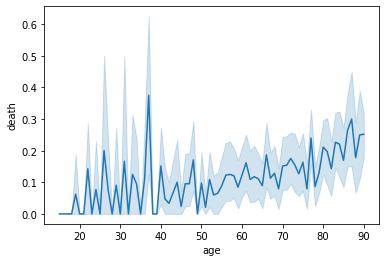

In [57]:
sns.lineplot(data=raw_df[raw_df.group=='train'], x="age", y="death")

<AxesSubplot:xlabel='age_trunc', ylabel='death'>

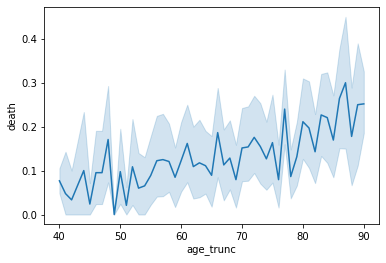

In [58]:
raw_df['age_trunc'] = raw_df['age'].clip(40,90)
sns.lineplot(data=raw_df[raw_df.group=='train'], x="age_trunc", y="death")

## gender
Gender is such a small difference it's likely not worth adding to the model

In [59]:
raw_df[raw_df.group=='train'].groupby('gender').agg({'death': ['mean','count']})

death      
            mean count
gender                
-1.0    0.000000     2
 0.0    0.141931  1388
 1.0    0.130387  1810

## icutype
There feature `icu_type` has a good split between the risk of death.  This will be added as a categorical variable to the model
1. Coronary Care Unit
1. Cardiac Surgery Recovery Unit
1. Medical ICU 
1. Surgical ICU

In [60]:
raw_df[raw_df.group=='train'].groupby('icutype').agg({'death': ['mean','count']})

death      
             mean count
icutype                
1.0      0.145652   460
2.0      0.037681   690
3.0      0.185430  1208
4.0      0.137767   842

In [61]:
# Create separate categorical values for each icutype
raw_df['coronary'] = np.where(raw_df.icutype==1,1,0)
raw_df['cardiac'] = np.where(raw_df.icutype==2,1,0)
raw_df['medical'] = np.where(raw_df.icutype==3,1,0)
raw_df['surgical'] = np.where(raw_df.icutype==4,1,0)

## bun_delta_trunc
Reviewing the `bun` variable it appears the risk of death tops out around 60 before the values become become less reliant

<AxesSubplot:xlabel='bun_median_round', ylabel='death'>

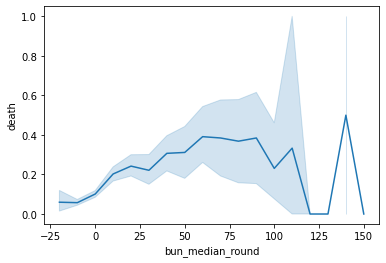

In [62]:
disp_df = raw_df.loc[raw_df.group=='train',['death','bun_delta_median']]
disp_df['bun_median_round'] = disp_df.bun_delta_median.round(-1)
sns.lineplot(data=disp_df, x="bun_median_round", y="death")
del disp_df

<AxesSubplot:xlabel='bun_delta_trunc', ylabel='death'>

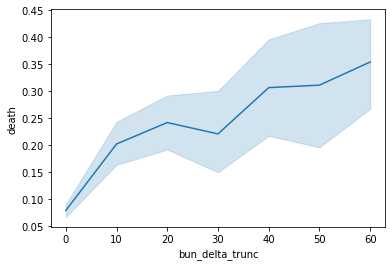

In [63]:
raw_df['bun_delta_trunc'] = raw_df['bun_delta_median'].clip(0,60)
disp_df = raw_df.loc[raw_df.group=='train',['death','bun_delta_trunc']]
disp_df['bun_delta_trunc'] = disp_df.bun_delta_trunc.round(-1)
sns.lineplot(data=disp_df, x="bun_delta_trunc", y="death")
del disp_df

## nidiasabp_delta_trunc
The variable `nidiasabp_delta_median` will be truncated at -20 and 50

<AxesSubplot:xlabel='nidiasabp_delta_round', ylabel='death'>

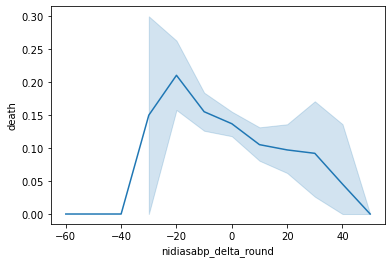

In [64]:
disp_df = raw_df.loc[raw_df.group=='train',['death','nidiasabp_delta_median']]
disp_df['nidiasabp_delta_round'] = disp_df.nidiasabp_delta_median.round(-1)
sns.lineplot(data=disp_df, x="nidiasabp_delta_round", y="death")
del disp_df

<AxesSubplot:xlabel='nidiasabp_delta_trunc', ylabel='death'>

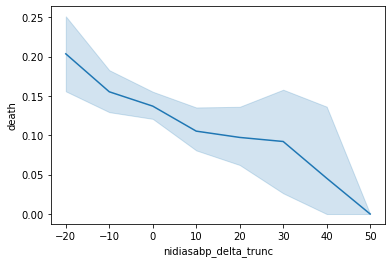

In [65]:
raw_df['nidiasabp_delta_trunc'] = raw_df['nidiasabp_delta_median'].clip(-20,50)
disp_df = raw_df.loc[raw_df.group=='train',['death','nidiasabp_delta_trunc']]
disp_df['nidiasabp_delta_trunc'] = disp_df.nidiasabp_delta_trunc.round(-1)
sns.lineplot(data=disp_df, x="nidiasabp_delta_trunc", y="death")
del disp_df

## temp_delta_trunc
The patients median temperature appears to be related to the risk of death specifically if the patient is colder.  This value from the median will be truncated at -1.5 and 0 as it appears to separate the data best.

<AxesSubplot:xlabel='temp_delta_round', ylabel='death'>

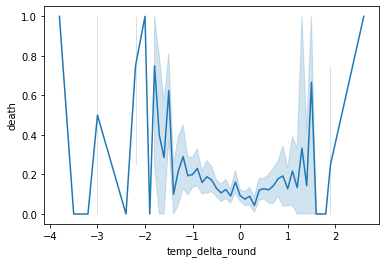

In [66]:
disp_df = raw_df.loc[raw_df.group=='train',['death','temp_delta_median']]
disp_df['temp_delta_round'] = disp_df.temp_delta_median.round(1)
sns.lineplot(data=disp_df, x="temp_delta_round", y="death")
del disp_df

<AxesSubplot:xlabel='temp_delta_trunc', ylabel='death'>

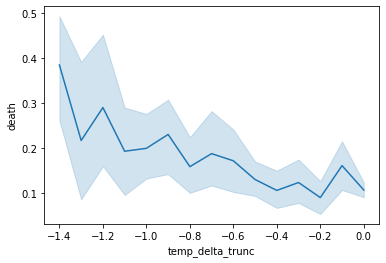

In [67]:
raw_df['temp_delta_trunc'] = raw_df['temp_delta_median'].clip(-1.4,0)
disp_df = raw_df.loc[raw_df.group=='train',['death','temp_delta_trunc']]
disp_df['temp_delta_trunc'] = disp_df.temp_delta_trunc.round(1)
sns.lineplot(data=disp_df, x="temp_delta_trunc", y="death")
del disp_df

## lactate_delta_trunc
The variable `lactate_delta_trunc` is correlated with death and wil be truncated at 0 and 7

<AxesSubplot:xlabel='lactate_delta_round', ylabel='death'>

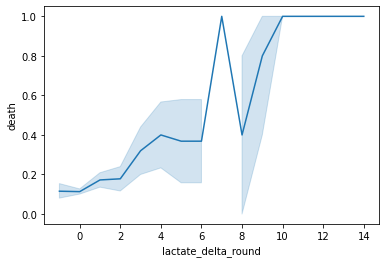

In [68]:
disp_df = raw_df.loc[raw_df.group=='train',['death','lactate_delta_median']]
disp_df['lactate_delta_round'] = disp_df.lactate_delta_median.round(0)
sns.lineplot(data=disp_df, x="lactate_delta_round", y="death")
del disp_df

<AxesSubplot:xlabel='lactate_delta_trunc', ylabel='death'>

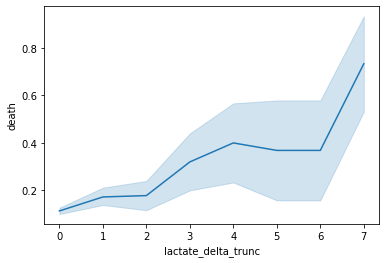

In [69]:
raw_df['lactate_delta_trunc'] = raw_df['lactate_delta_median'].clip(0,7)
disp_df = raw_df.loc[raw_df.group=='train',['death','lactate_delta_trunc']]
disp_df['lactate_delta_trunc'] = disp_df.lactate_delta_trunc.round(0)
sns.lineplot(data=disp_df, x="lactate_delta_trunc", y="death")
del disp_df

## gcs_day12_trunc
The difference in the day1 `gcs` score and the day2 `gcs` score is highly correlated with death.  An improving score is negativly associated with death.  Tuncation at -1 and 10 will be applied prior to modelin.

<AxesSubplot:xlabel='gcs_day12_round', ylabel='death'>

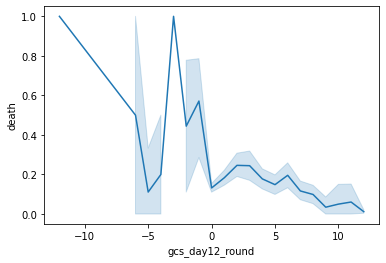

In [70]:
disp_df = raw_df.loc[raw_df.group=='train',['death','gcs_day12_delta']]
disp_df['gcs_day12_round'] = disp_df.gcs_day12_delta
sns.lineplot(data=disp_df, x="gcs_day12_round", y="death")
del disp_df

<AxesSubplot:xlabel='gcs_day12_trunc', ylabel='death'>

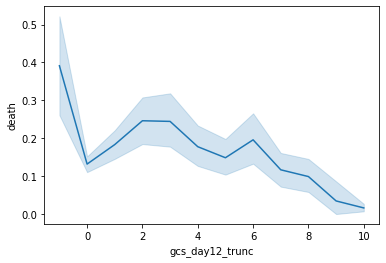

In [71]:
raw_df['gcs_day12_trunc'] = raw_df['gcs_day12_delta'].clip(-1,10)
disp_df = raw_df.loc[raw_df.group=='train',['death','gcs_day12_trunc']]
disp_df['gcs_day12_trunc'] = disp_df.gcs_day12_trunc.round(0)
sns.lineplot(data=disp_df, x="gcs_day12_trunc", y="death")
del disp_df

# Develop Models
The prediciton models will be developed in this section.  

## Regression
A logistic regression model will be performed on the training data set.  All variables of interest will be included and and those that are not statistically significant will be removed over several iterations.  Once a parsimonious model is developed the testing set will be scored. 

### Data

In [72]:
# Review the columns and decide what to add to the training data
raw_df.columns

Index(['death', 'group', 'age', 'gender', 'height', 'icutype', 'has_albumin',
       'has_alt', 'has_gcs', 'has_paco2', 'has_resprate', 'has_troponini',
       'has_troponint', 'bun_delta_median', 'lactate_delta_median',
       'nidiasabp_delta_median', 'temp_delta_median', 'gcs_day12_delta',
       'age_trunc', 'coronary', 'cardiac', 'medical', 'surgical',
       'bun_delta_trunc', 'nidiasabp_delta_trunc', 'temp_delta_trunc',
       'lactate_delta_trunc', 'gcs_day12_trunc'],
      dtype='object')

In [73]:
# Identify the features to include in the model
feature_list = ['cardiac', 'coronary','age_trunc',
                'has_alt', 'has_paco2', 'has_resprate', 'has_troponini',
                'bun_delta_trunc','temp_delta_trunc','lactate_delta_trunc', 
                'gcs_day12_trunc']

# Training Population
train_pop = raw_df.group == 'train'
x_train = raw_df.loc[train_pop, feature_list]
x_train = sm.add_constant(x_train)
y_train = raw_df.loc[train_pop,'death']

# Testing Population
test_pop = raw_df.group =='test'
x_test = raw_df.loc[test_pop, feature_list]
x_test = sm.add_constant(x_test)
y_test = raw_df.loc[test_pop,'death']

### Run Model 

* Perform logistic regression model
* Save predictions as `y_train_proba` to for future summary statistics.
* Print the logistic regression Summary

In [74]:
log_reg = sm.Logit(y_train, x_train).fit()
y_train_proba = log_reg.predict(x_train)
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.314817
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                 3200
Model:                          Logit   Df Residuals:                     3188
Method:                           MLE   Df Model:                           11
Date:                Sun, 09 Oct 2022   Pseudo R-squ.:                  0.2057
Time:                        21:16:32   Log-Likelihood:                -1007.4
converged:                       True   LL-Null:                       -1268.4
Covariance Type:            nonrobust   LLR p-value:                6.851e-105
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.4086      0.343    -12.871      0.000      -5.080      -3.737
ca

### ROC
Calcuate the area under the receiving operator curve and print the ROC curve.  This statistic is good for undestanding the discrimination of a model.

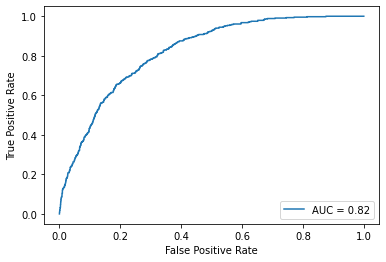

In [75]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_proba)
roc_auc = metrics.auc(fpr, tpr)
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

### Calibration Plot
A Calibration Plot is useful to understand if the prediction values scored by the model are realistic.  A model can have good discrimination but be poorly calibrated and vice versa.  For this calibration please note the following:

* The predictions were split into deciles
* The predicted vs actual values were calculated and plotted against each other
* A perfectly calibrated model would be along the diagonal

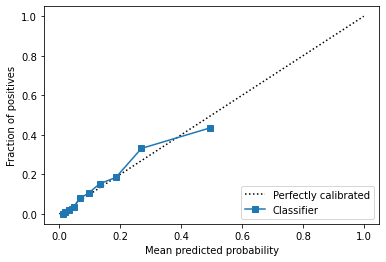

In [76]:
CalibrationDisplay.from_predictions(y_train, y_train_proba, n_bins=10, strategy = 'quantile')

### Precision/Recall
A precision recall classification report was created with an arbitrary cut point. 

In [77]:
y_train_class = y_train_proba > .25
print(metrics.classification_report(y_train, y_train_class, target_names=['Survive','Death']))

              precision    recall  f1-score   support

     Survive       0.92      0.88      0.90      2767
       Death       0.40      0.49      0.44       433

    accuracy                           0.83      3200
   macro avg       0.66      0.69      0.67      3200
weighted avg       0.85      0.83      0.84      3200



### Confusion Matrix
Below is the confusion matrix

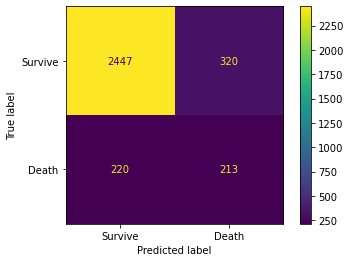

In [78]:
cm = metrics.confusion_matrix(y_train, y_train_class)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Survive','Death']).plot()

# Validate Models

## Score Model

In [79]:
# Score the testing dat set
y_test_proba = log_reg.predict(x_test)

## ROC
The AUC had a slight decrease between the training and testing data set (0.82 vs 0.79).  There doesn't appear to be doo much overfitting.

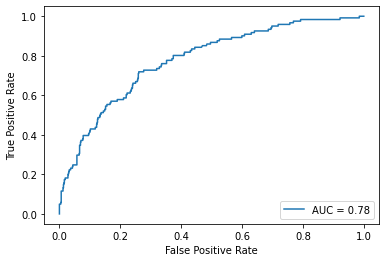

In [80]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_proba)
roc_auc = metrics.auc(fpr, tpr)
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

## Calibration
The testing set was not as well calibrated as the training set but it wasn't wildly off

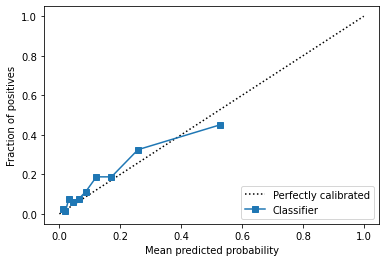

In [81]:
CalibrationDisplay.from_predictions(y_test, y_test_proba, n_bins=10, strategy = 'quantile')

## Precision/Recall
Using a 25% threshold there was a drop in the precision and recall although it wasn't too much

In [82]:
y_test_class = y_test_proba > .25
print(metrics.classification_report(y_test, y_test_class, target_names=['Survive','Death']))

              precision    recall  f1-score   support

     Survive       0.90      0.90      0.90       679
       Death       0.43      0.43      0.43       121

    accuracy                           0.83       800
   macro avg       0.66      0.66      0.66       800
weighted avg       0.83      0.83      0.83       800



## Confusion Matrix

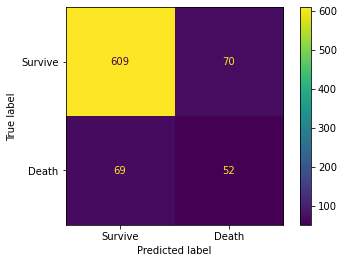

In [83]:
cm = metrics.confusion_matrix(y_test, y_test_class)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Survive','Death']).plot()